# **UCB W207 Final Project**

## Using Machine Learning to Predict Travel Review Sentiment

Section 3
18 April 2025

Kevin Yi, Kritin Nandish, Thrishna Bhandari, Patrick Abousleiman


# Introduction: Problem Motivation



## Outline for our notebook

* Section 1: We import the data, the source being the Tripadvisor Hotel Review Dataset file with 20K reviews, from the publication: Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic senti- ment: modeling semantic aspects for online reviews. Information Sci- ences 339, 206–223.
* Section 2: We undertake feature engineering and data cleaning. We did xyz....
* Section 3: Simple exploratory data analysis is performed. We found xyx...
* Section 4:  We build several models, starting from the baseline model, logistic regression with one hot encoding, logistic regression with embedding, and multilayer RNN.
* Section 5:  Conclusions from our analysis. 

In [24]:
# Import the libraries we'll use below.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns 
sns.set(style="darkgrid") 
import plotly.graph_objs as plotly  
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras import models


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import keras_tuner as kt
from keras_tuner import HyperModel, Hyperband
import regex as re
import tqdm


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split

# BERT
import transformers
from transformers import  AutoTokenizer, TFAutoModel
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.metrics import AUC, Precision
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#setting  seed
np.random.seed(100)




# Section 1: Importing data

Our main data source is the US Securities Exchange Commission (SEC), Genderize.io, Yahoo Finance. The data are not processed. 

The features included year, Total (which denotes total compensation: a summation of salary, stock awards, option awards, non-equity incentive compensation and other compensation), Market Cap (stock price * shares outstanding), last and first names, sector (such a technology) and industry (a further classification of sector). 

The original data frame consists of 293,504 rows and 19 features.

In [2]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

#Data Investigation
#We are considering reviews of ratings 3 as negative reviews.
positive_reviews = data[data['Rating'] >= 4]
negative_reviews = data[data['Rating'] <= 3]
print(f"In this dataset of {data.shape[0]} total hotel ratings, there are {positive_reviews.shape[0]} positive ratings, and {negative_reviews.shape[0]} negative hotel ratings.")


In this dataset of 20491 total hotel ratings, there are 15093 positive ratings, and 5398 negative hotel ratings.


# Section 2: Feature engineering

The data required a great deal of cleaning. We noted several issues, including non-sensical values; for example, market capitilization, which is the price of the stock times the shares outstanding was -1 in some rows(impossible) or zero. We filtered the dataframe to remove any irrelevant values.

We also catergorized C-suite job titles and produced bins for salary ranges (which were extremely wide). We binarized male/females.  Lastly, we normalized data for market cap and total compensation. 

After cleaning, the dataframe has 18,081 rows and 24 features. There is a large skew towards men (85% of the rows) and thus we rebalance the data to be a 50/50 split.  After the rebalancing, the training and test dataframe has 2,662 rows each. 




In [3]:
#Data Preprocessing
#checking null values
missing_values = data['Rating'].isnull().any() or data['Review'].isnull().any() # equals False
#There are no missing values in either data column.

In [4]:
#Preprocessing Functions
def preprocessor(text): 
    #Data cleaning
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

def replace_contractions(df, column_name):
    #Replace contractions
    df[column_name] = df[column_name].str.replace(r"ca n't\b", "can not", regex=True)
    df[column_name] = df[column_name].str.replace(r"n't\b", "not", regex=True)
    df[column_name] = df[column_name].str.replace(r"n t\b", "not", regex=True)
    return df

<>:5: SyntaxWarning: invalid escape sequence '\)'
<>:6: SyntaxWarning: invalid escape sequence '\W'
<>:5: SyntaxWarning: invalid escape sequence '\)'
<>:6: SyntaxWarning: invalid escape sequence '\W'
/var/folders/m4/fm146hdx4p162ttl_yhvy__w0000gn/T/ipykernel_45576/1337026894.py:5: SyntaxWarning: invalid escape sequence '\)'
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
/var/folders/m4/fm146hdx4p162ttl_yhvy__w0000gn/T/ipykernel_45576/1337026894.py:6: SyntaxWarning: invalid escape sequence '\W'
  text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))


In [5]:
#Apply preprocessing
data['Review'] = data['Review'].str.lower()
data['Review'] = data['Review'].apply(preprocessor)

data = replace_contractions(data, 'Review')
data
#We found one row with several typos that we cannot discern the original meaning and will be removing it from the data
data = data.drop(index=2759)

data = data.reset_index(drop=True)

#Redefine negative and positive data subsets with clean data
positive_reviews = data[data['Rating'] >= 4]
negative_reviews = data[data['Rating'] <= 3]

In [6]:
#Redefine data with binary classification for reviews. We combine 0-3 ratings as 0 and 4-5 as 1
data['Rating'] = data['Rating'].apply(lambda x: 0 if x <= 3 else 1)


# Section 3: Exploratory Data Analysis


Some findings from EDA:
 
*   US executives of large publicly-traded companies have very high total compensation, and the deviations are extremely large.
*   Very few women executives earning at the top compensation levels.
*  Female CEOs out earn males on average but no female CEOS earning top compensation



### Histograms to analyze data

There is a large spread in compensation, ranging from around 250,000 to 100 million. We noted that most of the compensation is clustered around the lower end of compensation and we analyze by select positions, with CEOs male earning the most and with the largest range in compensation. 

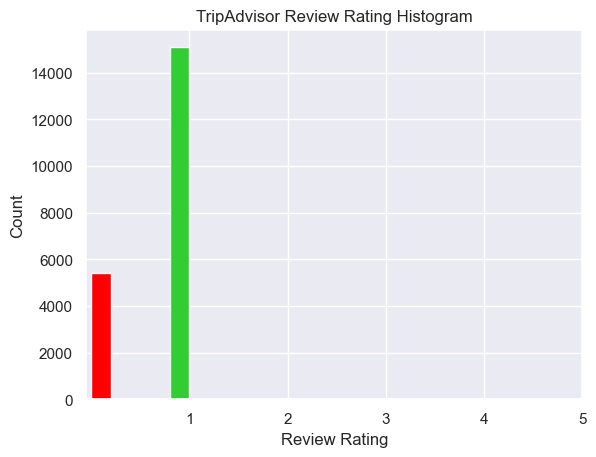

In [7]:
sns.histplot(data['Rating'], bins=5, kde=False) #create histogram of ratings in full dataset

# get the bins to modify color
ax = plt.gca()
patches = ax.patches

# assign colors to bins, shades of red for negative ratings, grey for neutral, shades of green for positive ratings
colors = ['red', 'tomato', 'salmon', 'chartreuse', 'limegreen']
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# set title, labels, and x-axis labels
plt.xticks([1, 2, 3, 4, 5]) 
plt.title("TripAdvisor Review Rating Histogram")
plt.xlabel("Review Rating")
plt.show()

### Word Cloud analyze data


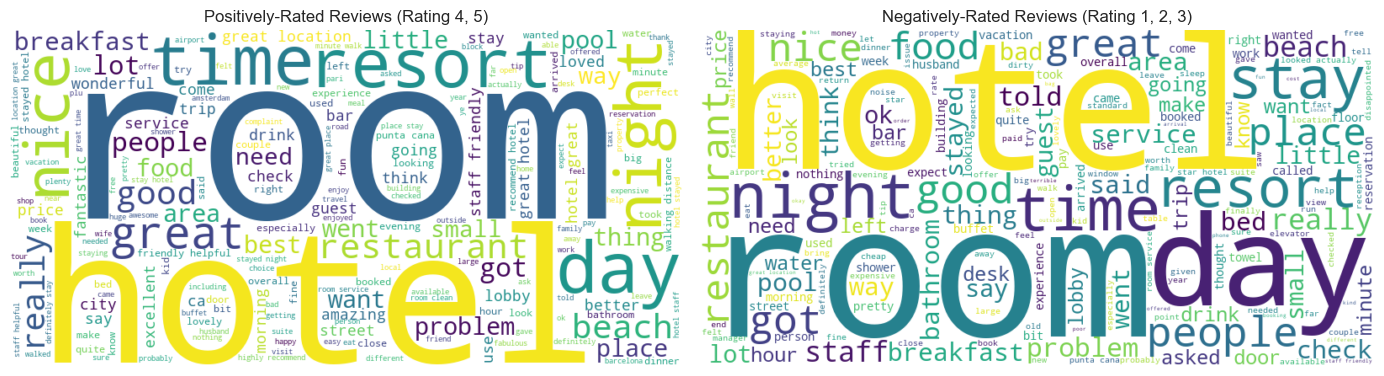

In [8]:
# create a word cloud for negative reviews
negative_review_text = " ".join(negative_reviews['Review'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_review_text)

# create a word cloud for positive reviews
positive_review_text = " ".join(positive_reviews['Review'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_review_text)

# set up the figure with two side-by-side subplots for the positive review and negative review word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Positively-Rated Reviews (Rating 4, 5)") # set title
axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Negatively-Rated Reviews (Rating 1, 2, 3)") # set title

# show the plots
plt.tight_layout()
plt.show()

### View Review length

Counts for positive reviews: 
 Minimum: 41 
 Max: 12356 
 Mean: 682.0227257669118

Counts for negative reviews: 
 Minimum: 45 
 Max: 13239 
 Mean: 792.8273114693349


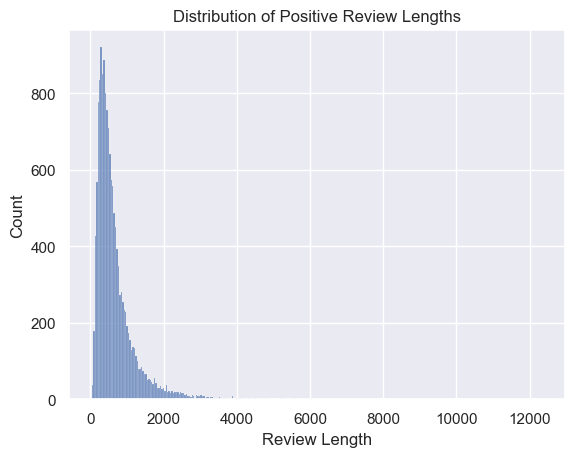

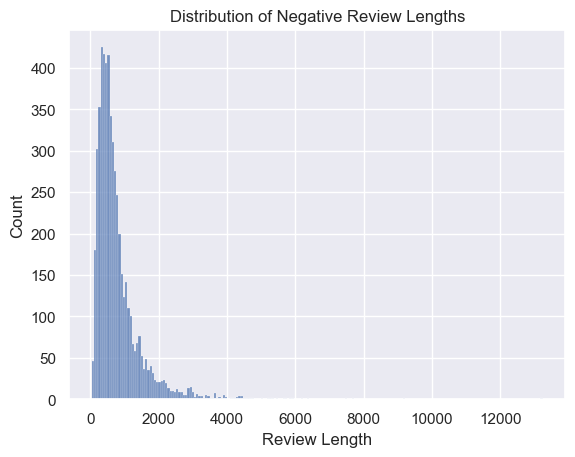

In [9]:
# get min, max, mean lengths for positive reviews. 
pos_reviews_length = [len(review) for review in positive_reviews['Review']]
min_pos = min(pos_reviews_length)
max_pos = max(pos_reviews_length)
mean_pos = sum(pos_reviews_length) / len(pos_reviews_length)

# get min, max, mean lengths for negative reviews. 
neg_reviews_length = [len(review) for review in negative_reviews['Review']]

min_neg = min(neg_reviews_length)
max_neg = max(neg_reviews_length)
mean_neg = sum(neg_reviews_length) / len(neg_reviews_length)

print(f'Counts for positive reviews: \n Minimum: {min_pos} \n Max: {max_pos} \n Mean: {mean_pos}')
print(f'\nCounts for negative reviews: \n Minimum: {min_neg} \n Max: {max_neg} \n Mean: {mean_neg}')

# Create histogram of positive review length counts. 
sns.histplot(pos_reviews_length)
plt.title('Distribution of Positive Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()


# Create histogram of negative review length counts. 
sns.histplot(neg_reviews_length)
plt.title('Distribution of Negative Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

### Split Data into training, validation, and testing

In [10]:
# shuffle data -- data will be the biased data with either a positive or negative review

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(0, data.shape[0]) #create indices list
shuffled_indices = np.random.permutation(indices) #shuffle indices
reviews = data['Review'] #create examples
ratings = data['Rating'] #create labels
reviews = reviews[shuffled_indices] #reorder dataset to match shuffled indices
ratings = ratings[shuffled_indices] #reorder dataset to match shuffled indices
    
# create data splits
X_train, X_test, Y_train, Y_test = train_test_split(reviews, ratings, random_state=1234, test_size=.20) #split data into training/testing datasets
X_test, X_val, Y_test, Y_val = train_test_split(X_train, Y_train, random_state=1234, test_size=.25) #split data into testing/validation datasets

### Analyze split data 

In [11]:
# print shapes
print('Shape of train examples ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of val examples ', X_val.shape)
print('Shape of val labels ', Y_val.shape)

print('Shape of test examples ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

Shape of train examples  (16392,)
Shape of train labels  (16392,)
Shape of val examples  (4098,)
Shape of val labels  (4098,)
Shape of test examples  (12294,)
Shape of test labels  (12294,)


### Tokenize data


In [12]:
# Initialize Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")

# Fit the tokenizer on the X_train data (only fit on training data)
tokenizer.fit_on_texts(X_train)

# Convert the reviews to sequences of integers (tokens)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
X_val_tokens = tokenizer.texts_to_sequences(X_val)

# Pad the data to ensure they are all the same length (maxlen=2000)
X_train_padded = pad_sequences(X_train_tokens, maxlen=2000, dtype='int32', padding='post', truncating='post', value=0)
X_test_padded = pad_sequences(X_test_tokens, maxlen=2000, dtype='int32', padding='post', truncating='post', value=0)
X_val_padded = pad_sequences(X_val_tokens, maxlen=2000, dtype='int32', padding='post', truncating='post', value=0)

print(X_train_padded.shape)
print(X_train_padded[0])

(16392, 2000)
[  5   3 560 ...   0   0   0]


# Section 4: Model building and predictions.

We build a simple model to start, using 1 feature, gender and one layer (model 1).  We then add on other features and multi layers (model2, model3 and model4). In Model5, we use a one-hot encoding to transform the catergorical variable, sector and run a multi-layer 12 feature model. 

## Model 1: Baseline Model (Majority Class - Positive Reviews) 
We train a baseline model that will always predict the review to be positive based on our training data (the majority class). These are metrics we will aim to surpass by our last model. This model provides a baseline measure to try and beat.

In [19]:
y_test_baseline = [1] * len(Y_test)
y_val_baseline = [1] * len(Y_val)

y_test = np.array(Y_test)
y_val = np.array(Y_val)
y_test_baseline = np.array(y_test_baseline)
y_val_baseline = np.array(y_val_baseline)


test_precision = precision_score(Y_test, y_test_baseline, average='binary', zero_division=0)
test_recall = recall_score(Y_test, y_test_baseline, average='binary', zero_division=0)

val_precision = precision_score(Y_val, y_val_baseline, average='binary', zero_division=0)
val_recall = recall_score(Y_val, y_val_baseline, average='binary', zero_division=0)

y_test_probs = [1.0 if pred == 1 else 0.0 for pred in y_test_baseline]
y_val_probs = [1.0 if pred == 1 else 0.0 for pred in y_val_baseline]

test_auc = roc_auc_score(Y_test, y_test_probs)
val_auc = roc_auc_score(Y_val, y_val_probs)

print(f"Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, AUC: {test_auc:.4f}")
print(f"Val  Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, AUC: {val_auc:.4f}")

Test Precision: 0.7385, Recall: 1.0000, AUC: 0.5000
Val  Precision: 0.7404, Recall: 1.0000, AUC: 0.5000


## Tuning Hyperparameters

We experiment with different optimizers and learning rates.  We find that Adam optimizer plus learning rate of 0.01 has the best convergence of the loss and validation loss.


Model | Optimizer | Learning rate | Loss | Val Loss
-|-|-|-|-|
Model 1: Gender|SGD|0.01|0.046|0.049|
Model 1: Gender|SGD|0.001|0.700|1.344|
Model 1: Gender|SGD|0.0001|1.476|2.801|
Model 1: Gender|Adam|0.01|0.0359|0.0362|
Model 1: Gender|Adam|0.001|1.038|1.934|

## Model 2: One Hot Encoding Regression

We used a one hot encoded logistcal regression model for our initial model.

In [31]:

vocab_size = 1000  # smaller vocab to avoid memory issues
maxlen = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)


X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')


X_train_oh = tf.one_hot(X_train_pad, depth=vocab_size)
X_val_oh = tf.one_hot(X_val_pad, depth=vocab_size)
X_test_oh = tf.one_hot(X_test_pad, depth=vocab_size)


def build_onehot_model(average_over_positions=False):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential()

    if average_over_positions:
        model.add(tf.keras.layers.GlobalAveragePooling1D(input_shape=(maxlen, vocab_size)))
    else:
        model.add(tf.keras.layers.Flatten(input_shape=(maxlen, vocab_size)))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', AUC(name='auc')]
    )
    
    return model


model = build_onehot_model(average_over_positions=True)

history = model.fit(
    X_train_oh, Y_train,
    validation_data=(X_val_oh, Y_val),
    epochs=5,
    batch_size=64,
    verbose=1
)
y_train_probs = model.predict(X_train_oh)
y_val_probs = model.predict(X_val_oh)

y_train_pred = (y_train_probs >= 0.5).astype(int).flatten()
y_val_pred = (y_val_probs >= 0.5).astype(int).flatten()

print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(Y_train, y_train_pred))
print("Precision:", precision_score(Y_train, y_train_pred))
print("Recall:", recall_score(Y_train, y_train_pred))
print("AUC:", roc_auc_score(Y_train, y_train_probs))

print("\n--- Validation Set Evaluation ---")
print("Accuracy:", accuracy_score(Y_val, y_val_pred))
print("Precision:", precision_score(Y_val, y_val_pred))
print("Recall:", recall_score(Y_val, y_val_pred))
print("AUC:", roc_auc_score(Y_val, y_val_probs))


Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/pooling/base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7314 - auc: 0.5242 - loss: 0.6674 - val_accuracy: 0.7404 - val_auc: 0.6607 - val_loss: 0.6124
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7393 - auc: 0.6194 - loss: 0.6025 - val_accuracy: 0.7404 - val_auc: 0.6945 - val_loss: 0.5789
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7393 - auc: 0.6869 - loss: 0.5752 - val_accuracy: 0.7404 - val_auc: 0.7107 - val_loss: 0.5646
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7393 - auc: 0.7149 - loss: 0.5632 - val_accuracy: 0.7404 - val_auc: 0.7212 - val_loss: 0.5572
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7393 - auc: 0.7280 - loss: 0.5566 - val_accuracy: 0.7404 - val_auc: 0.7292 - val_loss: 0.5519
513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Training Set Evaluation ---
Accuracy: 0.7389580283064909
Precision: 0.7389580283064909
Recall: 1.0
AUC: 0.7339511047011985

--- 

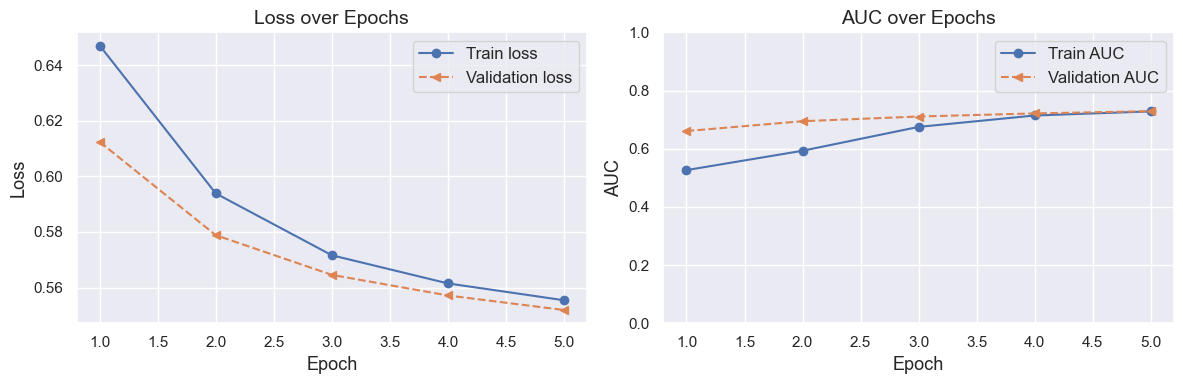

In [32]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

# Plot loss and AUC
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=13)
ax.set_ylabel('Loss', size=13)
ax.set_title('Loss over Epochs', size=14)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train AUC')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation AUC')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=13)
ax.set_ylabel('AUC', size=13)
ax.set_ylim(0, 1)
ax.set_title('AUC over Epochs', size=14)

plt.tight_layout()
plt.show()

In [33]:
y_probs = model.predict(X_test_oh)
y_pred = (y_probs >= 0.5).astype(int).flatten()

# Metrics
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("AUC:", roc_auc_score(Y_test, y_probs))

385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.7384903204815357
Precision: 0.7384903204815357
Recall: 1.0
AUC: 0.7352090523188799


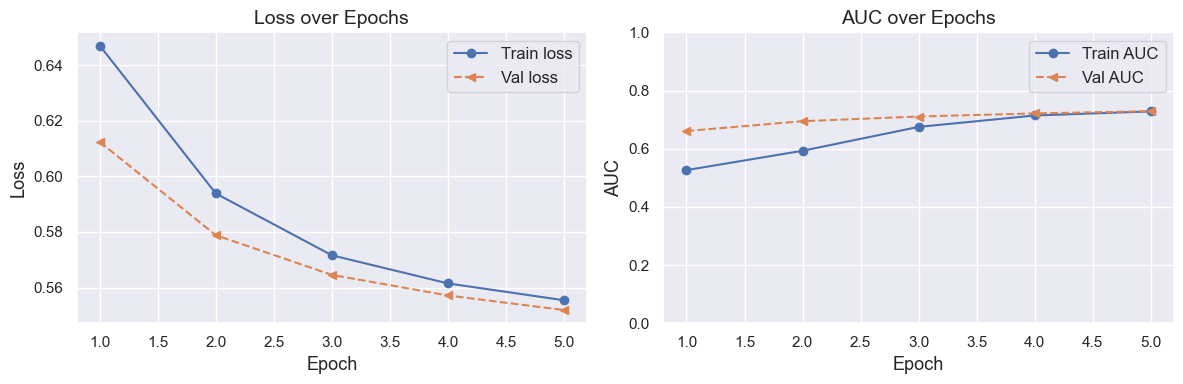

In [34]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))

# ---- Loss Plot ----
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Val loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=13)
ax.set_ylabel('Loss', size=13)
ax.set_title('Loss over Epochs', size=14)

# ---- AUC Plot ----
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train AUC')
ax.plot(x_arr, hist['val_auc'], '--<', label='Val AUC')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=13)
ax.set_ylabel('AUC', size=13)
ax.set_ylim(0, 1)
ax.set_title('AUC over Epochs', size=14)

plt.tight_layout()
plt.show()

## Model 3: Logistic regression with embeddings

In [25]:
def build_embeddings_model(average_over_positions=True,
                           vocab_size=5000,
                           sequence_length=16392,
                           embedding_dim=64):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
      
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))
  model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision')]
  )



  return model

In [26]:

model2 = build_embeddings_model(average_over_positions=True,
                               vocab_size=5000,
                               sequence_length=16392,
                               embedding_dim=2)
history2 = model2.fit(
  x = X_train_padded,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=10,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_data= (X_val_padded, Y_val), 
  verbose=1             # display some progress output during training
  )

model2.summary()

history2 = pd.DataFrame(history2.history)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7290 - auc: 0.5219 - loss: 0.5786 - precision: 0.7371 - val_accuracy: 0.7404 - val_auc: 0.6100 - val_loss: 0.5697 - val_precision: 0.7404
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7392 - auc: 0.5542 - loss: 0.5707 - precision: 0.7393 - val_accuracy: 0.7399 - val_auc: 0.6387 - val_loss: 0.5682 - val_precision: 0.7402
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7386 - auc: 0.5718 - loss: 0.5692 - precision: 0.7392 - val_accuracy: 0.7399 - val_auc: 0.6613 - val_loss: 0.5668 - val_precision: 0.7402
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7389 - auc: 0.5873 - loss: 0.5678 - precision: 0.7394 - val_accuracy: 0.7399 - val_auc: 0.6788 - val_loss: 0.5654 - val_precision: 0.7402
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7390 - auc: 0.6024 - loss: 0.5664 - precision: 0.7395 - val_accuracy: 0.7396 - val_auc: 0.6943 - val_loss: 0.5639 - va

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 2000, 2)        │        10,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 2)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,011 (117.23 KB)

 Trainable params: 10,003 (39.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,008 (78.16 KB)

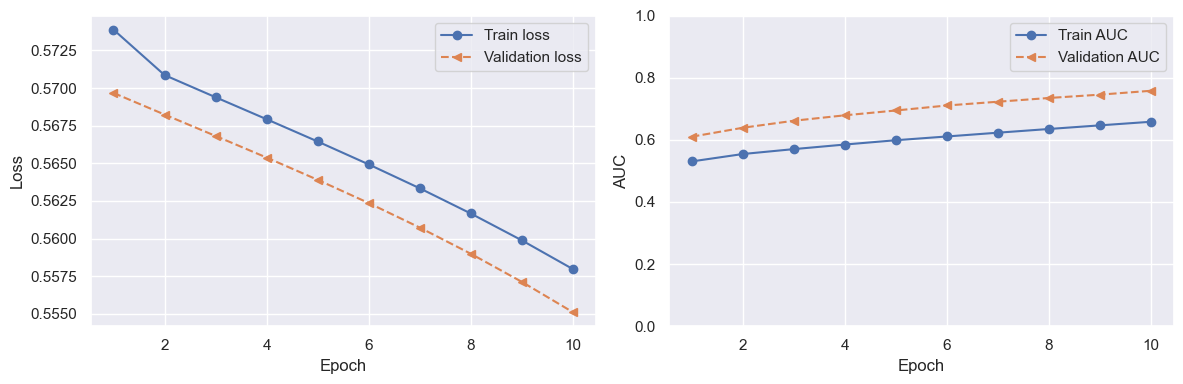

In [27]:
x_arr = np.arange(len(history2['loss'])) + 1

fig = plt.figure(figsize=(12, 4))

# Plot Loss
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_arr, history2['loss'], '-o', label='Train loss')
ax1.plot(x_arr, history2['val_loss'], '--<', label='Validation loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot AUC
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(x_arr, history2['auc'], '-o', label='Train AUC')
ax2.plot(x_arr, history2['val_auc'], '--<', label='Validation AUC')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [30]:
test_loss, test_accuracy, test_auc, test_precision = model2.evaluate(X_test_padded, Y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')

385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.7440 - auc: 0.7535 - loss: 0.5505 - precision: 0.7450
Test Loss: 0.5562417507171631
Test Accuracy: 0.7386530041694641
Test AUC: 0.7587915062904358
Test Precision: 0.7392722964286804


## Model 4: CNN Convolutional neural network with embdeddment and no hyperparameter tuning

In [13]:
# initialize model
model_tf = tf.keras.Sequential()

# Add embedding layer to map tokens to embeddings
model_tf.add(tf.keras.layers.Embedding(input_dim=8000,  # Vocabulary size 
                                      output_dim=100,  # Embedding size 
                                      input_length=250))  # Sequence length 

# add convolutional layer
model_tf.add(tf.keras.layers.Conv1D(
        filters=12,
        kernel_size=4,
        strides = 1, 
        padding='same',
        data_format = 'channels_last',
        name = 'conv_1',
        activation='relu'))

# add max pooling layer 
model_tf.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.3))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

# add the classification layer
model_tf.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# build and compile model
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')])

# print model_tf summary
model_tf.summary()


# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=3,                   # Stop after 3 epochs of no improvement
    restore_best_weights=True     # Restore best model weights after stopping
)

# train model_tf on (X_train, y_train) data
history = model_tf.fit(
    X_train_padded,
    Y_train,
    validation_data= (X_val_padded, Y_val),
    epochs=10,
    callbacks=[early_stopping]   # Add early stopping 
)


/Users/kevinyi/tf_metal/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-07 22:07:42.532978: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-07 22:07:42.533334: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-07 22:07:42.533380: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-07 22:07:42.533675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-07 22:07:42.533695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-04-07 22:07:43.011462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


513/513 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.7710 - auc: 0.7802 - loss: 1.0032 - precision: 0.8162 - recall: 0.8923 - val_accuracy: 0.9207 - val_auc: 0.9644 - val_loss: 0.2102 - val_precision: 0.9329 - val_recall: 0.9621
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9082 - auc: 0.9543 - loss: 0.2400 - precision: 0.9281 - recall: 0.9495 - val_accuracy: 0.9453 - val_auc: 0.9848 - val_loss: 0.1393 - val_precision: 0.9524 - val_recall: 0.9750
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9274 - auc: 0.9667 - loss: 0.2118 - precision: 0.9448 - recall: 0.9579 - val_accuracy: 0.9346 - val_auc: 0.9878 - val_loss: 0.1568 - val_precision: 0.9859 - val_recall: 0.9249
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9364 - auc: 0.9748 - loss: 0.1853 - precision: 0.9536 - recall: 0.9600 - val_accuracy: 0.9627 - val_auc: 0.9911 - val_loss: 0.0994 - val_precision: 0.9759 - val_recall: 0.9736
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━

Print out the loss and AUC curve of our final model on test data


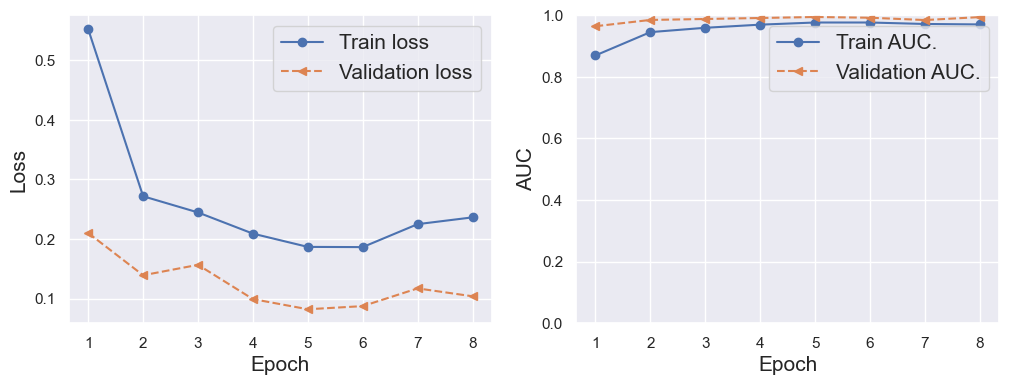

In [14]:
# plot loss curves
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)



# evaluate the AUC of model on (X_train_padded, y_train) and (X_val_padded, y_val)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train AUC.')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation AUC.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('AUC', size=15)
ax.set_ylim(0,1)
plt.show()

Evaluate our model

In [15]:
# Evaluate the model on test data
test_loss, test_accuracy, test_auc, test_precision, test_recall = model_tf.evaluate(X_test_padded, Y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

385/385 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9704 - auc: 0.9926 - loss: 0.0900 - precision: 0.9811 - recall: 0.9792
Test Loss: 0.08913654834032059
Test Accuracy: 0.9699853658676147
Test AUC: 0.9928014874458313
Test Precision: 0.9798369407653809
Test Recall: 0.9795131683349609


## Model 5: CNN Convolutional neural network with hyperparameter tuning




In [16]:

#Fine-tune the number of hidden layers and the hyperparameters of model_cnn to determine the setup that yields the most optimal generalization performance.
class DRHyperModel(HyperModel):
    def build(self, hp):
        model_cnn = tf.keras.Sequential()

        # Embedding layer (input layer) for text data
        model_cnn.add(Embedding(
            input_dim=hp.Int('vocab_size', min_value=4000, max_value=8000, step=500),  # Vocabulary size (5000 to 8000)
            output_dim=hp.Int('embedding_dim', min_value=50, max_value=200, step=50),  # Embedding dimension (50 to 200)
            input_length=hp.Int('maxlen', min_value=100, max_value=500, step=50),  # Max sequence length (100 to 500)
        ))

        # Tune the number of convolutional layers (e.g., 2 to 5)
        num_conv_layers = hp.Int('num_conv_layers', min_value=2, max_value=5)

        for i in range(num_conv_layers):
            # Choose kernel_size as a string (e.g., '3', '5')
            kernel_size_str = hp.Choice(f'conv_{i+1}_kernel_size', values=['3', '5'])
            kernel_size = tuple(map(int, kernel_size_str.split('x')))  # Convert the string to a tuple

            model_cnn.add(Conv1D(
                filters=hp.Choice(f'conv_{i+1}_filters', values=[16, 32, 64, 128]),
                kernel_size=kernel_size,
                activation='relu',
                padding='same'
            ))
            model_cnn.add(MaxPooling1D(pool_size=2))  

        # Add a dropout layer after the last convolutional block
        model_cnn.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)))

        # Flatten before feeding into the dense layer
        model_cnn.add(Flatten())

        # Dense layer for classification
        model_cnn.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

        # Compile model
        model_cnn.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss=BinaryCrossentropy(),
               metrics=['accuracy',
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')
    ]
        )

        return model_cnn
    

# Initialize Hyperband Tuner
hypermodel = DRHyperModel()

tuner = Hyperband(
    hypermodel,
    objective='val_auc',
    max_epochs=5,   # Number of epochs for the full training process
    factor=3,        # Reduction factor for each bracket
    executions_per_trial=1,
    directory='my_tuning_dir',
    project_name='dr_tuning',
    overwrite = True
)


# Start the search
tuner.search(
    x=X_train_padded,
    y=Y_train,
    epochs=5,
    batch_size = 32,
    validation_data = (X_val_padded, Y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]   # Define early stopping
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Print the best hyperparameters
print(f"Best number of convolutional layers: {best_hps.get('num_conv_layers')}")
for i in range(best_hps.get('num_conv_layers')):
    print(f"Conv Layer {i+1} - Filters: {best_hps.get(f'conv_{i+1}_filters')}, "
          f"Kernel Size: {best_hps.get(f'conv_{i+1}_kernel_size')}")
    
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


# Retrain the best model 
history = best_model.fit(
    x=X_train_padded,
    y=Y_train,
    epochs=10,   # Adjust as needed
    validation_data = (X_val_padded, Y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)
best_model.summary()



Trial 10 Complete [00h 04m 09s]
val_auc: 0.9970772862434387

Best val_auc So Far: 0.9998881816864014
Total elapsed time: 00h 24m 01s
Best number of convolutional layers: 2
Conv Layer 1 - Filters: 128, Kernel Size: 5
Conv Layer 2 - Filters: 32, Kernel Size: 3
Best dropout rate: 0.30000000000000004
Best learning rate: 0.001691259749366025
Epoch 1/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 69s 131ms/step - accuracy: 0.8095 - auc: 0.8068 - loss: 0.4226 - precision: 0.8292 - recall: 0.9368 - val_accuracy: 0.9395 - val_auc: 0.9823 - val_loss: 0.1594 - val_precision: 0.9659 - val_recall: 0.9519
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 68s 133ms/step - accuracy: 0.9318 - auc: 0.9738 - loss: 0.1757 - precision: 0.9459 - recall: 0.9622 - val_accuracy: 0.9617 - val_auc: 0.9939 - val_loss: 0.1176 - val_precision: 0.9852 - val_recall: 0.9628
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 72s 141ms/step - accuracy: 0.9569 - auc: 0.9890 - loss: 0.1125 - precision: 0.9651 - recall: 0.9771 - val_accuracy: 0.9849 - val_au

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 2000, 200)      │     1,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2000, 128)      │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1000, 32)       │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,069,349 (15.52 MB)

 Trainable params: 1,356,449 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,712,900 (10.35 MB)

Print out the loss and AUC curve of our final model on test data

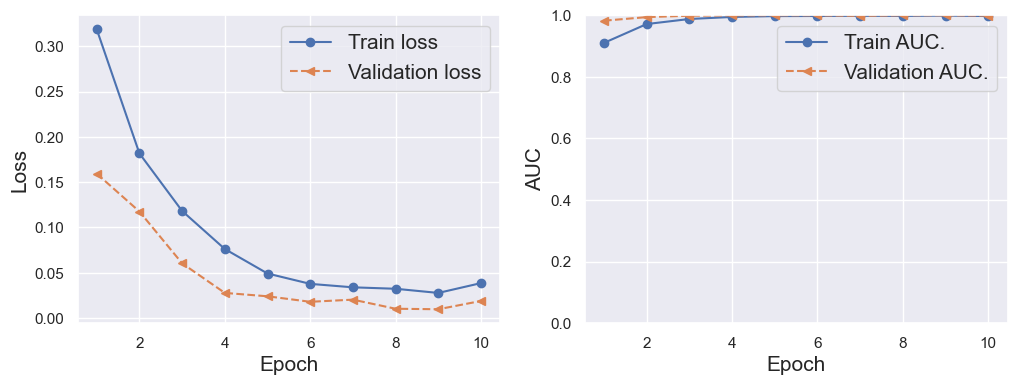

In [17]:
# plot loss curves
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)



# evaluate the AUC of model on (X_train_padded, y_train) and (X_val_padded, y_val)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train AUC.')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation AUC.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('AUC', size=15)
ax.set_ylim(0,1)
plt.show()

Evaluate our model

In [18]:


# Evaluate the model on test data
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(X_test_padded, Y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')


385/385 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9960 - auc: 0.9999 - loss: 0.0150 - precision: 0.9950 - recall: 0.9997
Test Loss: 0.015473746694624424
Test Accuracy: 0.9953635931015015
Test AUC: 0.9999115467071533
Test Precision: 0.9941936731338501
Test Recall: 0.9995594024658203


## Model 6: Fine Tuning Transformer Model 


We will start by defining functions we will use

In [ ]:
def tokenize(reviews, labels, tokenizer, seq_length):
    ''''''
    # tokenize reviews (this will give you: input_ids, attention_mask)
    reviews_tokenized = [
        tokenizer(
            n,
            return_tensors='tf',
            truncation=True,
            padding='max_length',
            max_length=seq_length) for n in reviews
    ]

    reviews_tokenized_tensor = tf.convert_to_tensor([
                            (reviews_tokenized[i]['input_ids'],
                              reviews_tokenized[i]['attention_mask'])
                         for i in range(len(reviews_tokenized))
    ])

    # remove empty dimension
    reviews_tokenized_tensor = reviews_tokenized_tensor[:,:,0,:]

    # tensor labels
    labels_tensor = np.array(labels)

    return reviews_tokenized_tensor, labels_tensor

In [15]:
def get_bert_embeddings(bert_auto_model, reviews_tokenized_tensor, feature_size=768):
    ''''''
    n = len(reviews_tokenized_tensor)
    seq_len = reviews_tokenized_tensor[0][0].shape[0]
    #bert_pool_embeddings = np.zeros((n, seq_len, feature_size)) # for token embeddings
    bert_pool_embeddings = np.zeros((n, feature_size)) # for sentence embeddings
    bs = 128
    nsteps = n//bs+1

    for i in tqdm.trange(n//bs+1):
        slc = slice(i*bs, (i+1)*bs)
        data = reviews_tokenized_tensor[slc]
        input_ids, attention_mask = data[:,0], data[:,1]
        #embedding = bert_auto_model(input_ids, attention_mask).last_hidden_state # for token embeddings
        embedding = bert_auto_model(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        bert_pool_embeddings[slc] = embedding

    return bert_pool_embeddings

Load the pre-trained distilbert-base-uncased-finetuned-sst-2-english tokenizer and model. This model is already fine tuned for sentiment task but we will fine tune it even further with our data

In [16]:
#from transformers import AutoTokenizer, TFAutoModel
hf_model = "distilbert-base-uncased-finetuned-sst-2-english"
if 'tokenizer' not in locals().keys(): tokenizer = AutoTokenizer.from_pretrained(hf_model)
if 'bert_auto_model' not in locals().keys(): bert_model = TFAutoModel.from_pretrained(hf_model)
tokenizer = AutoTokenizer.from_pretrained(hf_model)
bert_model = TFAutoModel.from_pretrained(hf_model)
bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['pre_class

Model: "tf_distil_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can now apply the tokenizer to our trainining, validation and test datasets. Max token that the model will accept is 512. 

In [17]:
train_reviews_tokenized_tensor, train_labels_tensor = tokenize(
    X_train, Y_train, tokenizer, seq_length=300
)

valid_reviews_tokenized_tensor, valid_labels_tensor = tokenize(
    X_val, Y_val, tokenizer, seq_length=300
)

test_reviews_tokenized_tensor, test_labels_tensor = tokenize(
    X_test, Y_test, tokenizer, seq_length=300
)

Create Sentence Embedding
We will use the bert_model imported above to generate text embeddings applied to our own data

In [18]:
print("Doing BERT train embeddings")
train_bert_embeddings = get_bert_embeddings(
    bert_model, train_reviews_tokenized_tensor[:16000,:,:]
) #do train_reviews_tokenized_tensor[:2000,:,:] for only 2000 examples

print("Doing BERT val embeddings")
valid_bert_embeddings = get_bert_embeddings(
    bert_model, valid_reviews_tokenized_tensor [:4000,:,:]
) #do valid_reviews_tokenized_tensor[:200,:,:] for only 200 examples

print("Doing BERT test embeddings")
test_bert_embeddings = get_bert_embeddings(
    bert_model, test_reviews_tokenized_tensor [:12000,:,:]
) #do test_reviews_tokenized_tensor[:200,:,:] for only 200 examples




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Doing BERT train embeddings


100%|██████████| 126/126 [32:14<00:00, 15.35s/it]


Doing BERT val embeddings


100%|██████████| 32/32 [08:07<00:00, 15.24s/it]


Doing BERT test embeddings


100%|██████████| 94/94 [24:38<00:00, 15.72s/it]


These embeddings are going to be our BERT features that we can next use in a downstream task.

We will fine-tune our BERT model on a downstream task of sentiment classification.
To do this, we will create a classifier by adding a `Dense` layer on top of the pretrained BERT features.

In [19]:
# unfreeze BERT layers
for layer in bert_model.layers:
    layer.trainable = True

In [20]:
# create copy of our objects (a bit inefficient (memory size) but let's abstract away from this)
train_x = train_bert_embeddings
train_y = train_labels_tensor[:16000] #do train_labels_tensor[:2000,:,:] for only 2000 examples if you subset the data above

valid_x = valid_bert_embeddings
valid_y = valid_labels_tensor[:4000]#do valid_labels_tensor[:200,:,:] for only 200 examples if you subset the data above

test_x = test_bert_embeddings
test_y = test_labels_tensor[:12000] #do test_labels_tensor[:200,:,:] for only 200 examples if you subset the data above

Define a model for our Downstream task

In [21]:
def build_model(num_features):

    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape=(num_features,), name='Input'))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output'))

    model.summary()

    # print model summary
    model.summary()

    return model

# Build the model
logit_model = build_model(num_features=train_x.shape[1])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ output (Dense)                  │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ output (Dense)                  │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# compile logit model
logit_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), 
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)



In [23]:
# train logit model
tf.random.set_seed(1234)
np.random.seed(1234)
hist= logit_model.fit(x=train_x,
                y=train_y,
                #validation_data=[X_test_std, y_test],
                validation_data=(valid_x, valid_y),
                batch_size=32,
                epochs=20,
                verbose=0 #silence fit
)

Print out the loss and AUC curve of our final model on test data


Text(0.5, 1.0, 'AUC')

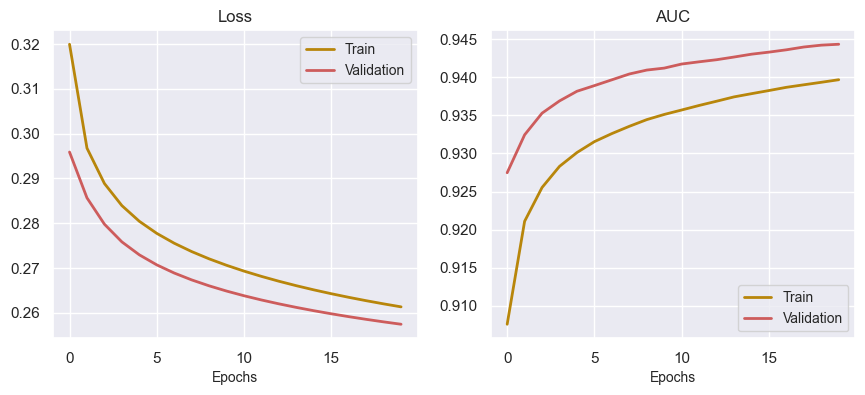

In [24]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# Plot AUC for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['auc'], lw=2, color='darkgoldenrod')  # Train AUC
plt.plot(history['val_auc'], lw=2, color='indianred')  # Validation AUC
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)  # Optional: Set limits for y-axis
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC')

Evaluate our fine tuned model

In [25]:
# run the trained model on the test data (the model outputs probabilities)
test_loss, test_accuracy, test_auc, test_precision, test_recall  = logit_model.evaluate(test_x, test_y)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')




375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - accuracy: 0.8977 - auc: 0.9428 - loss: 0.2570 - precision: 0.9016 - recall: 0.9683
Test Loss: 0.258743017911911
Test Accuracy: 0.8958333134651184
Test AUC: 0.9434587359428406
Test Precision: 0.8999685049057007
Test Recall: 0.9663770794868469


# Section 5: Conlusion / Comparing Models. 

